In [1]:
IRdisplay::display_html(file='code_hiding.html')

Toggle ON/OFF 
code cells.

In [2]:
# USEFUL COMMAND!
# example(data.table)

In [3]:
# load packages and define constants
library(data.table)     # see https://cran.r-project.org/web/packages/data.table/vignettes/datatable-intro.html for reference
library(ggplot2)        # for plots
library(repr)           # for resizing figures
library(OneR)           # to use the function 'bin'
source("R_functions.r") # custom functions

# folder/file-specific constants
PILOT_NUMBER <- 9
DATA_FOLDER <- "~/programing/data/psychophys/"
FIRA_TAG <- "FIRA"
FRAMES_TAG <- "framesInfo"
DOTS_TAG <- "dotsPositions"

# key-specific constants 
TRIALS <- "trials"
FRAMES <- "frames"
DOTS <- "dots"

# plot-specific constants
AXES_LABEL_FONT <- 18
AXES_FONT <- 15

# other variables
FRAME_RATE_ESTIMATE <- 60 # Hz
FRAME_DURATION <- (1 / FRAME_RATE_ESTIMATE) # sec

In [4]:
# load csv files into data.tables
tb <- list(
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FIRA_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, FRAMES_TAG),
    loadPilotCSV(PILOT_NUMBER, DATA_FOLDER, DOTS_TAG))
names(tb) <- c(TRIALS, FRAMES, DOTS)

# add a trialCount column to the TRIALS and FRAMES table
tb[[TRIALS]][,trialCount:=.I]
tb[[FRAMES]] <- tb[[FRAMES]][tb[[TRIALS]][,.(trialCount, trialIndex)],on="trialIndex"]
# add all the fields from the TRIALS table to the DOTS table for Reverse Kernel analysis
tb[[DOTS]] <- tb[[DOTS]][tb[[TRIALS]],on="trialCount"]
# also add an ID column 
# tb[[DOTS]][,ID:=.I]
# str(tb[[DOTS]])

# Introduction
## Notebook's goals

Analyze data collected on myself. Two subgoals:
1. make sure the task and stimulus behave as we want, to the smallest detail
2. start building up an analysis pipeline for the actual study

## A word on the data for this notebook
The tag for this data is `Pilot 9`. It was collected in the psychophysics booth with [this code](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/releases/tag/pilot9.mat).


## Workflow description
1. Task is run with repo [SingleCP_DotsReversal_Task](https://github.com/TheGoldLab/SingleCP_DotsReversal_Task/) (appropriate branch must be chosen).
  1. A `.mat` data file is outputted
  2. I usually manually rename this file `pilot_#.mat` and upload it to PennBox (Data/Psychophysics/Radillo_SingleCP_DotsReversal/)
2. Data is analyzed with repo [SingleCP_DotsReversal_DataAnalaysis](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis)(again, with the appropriate branch).
  1. The first step is to convert data from the .mat file into CSV format with [this script](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/blob/02109ab98b956f2aad4ac15f01e1d373260c8af0/MATLAB_scripts/mat2csv.m) 
    - `pilot#_framesInfo.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-description-of-*framesInfo.csv-file).
    - `pilot#_FIRA.csv`  [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-Description-of-*FIRA.csv-files).
    - `pilot#_dotsPositions.csv` [Fields description](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki/Fields-descriptions-for-*dotsPositions.csv-file).

**TO-DO**
- Write detailed explanation of each column in each `.csv` file (i.e. update the [Wiki](https://github.com/aernesto/SingleCP_DotsReversal_DataAnalysis/wiki))
- Make sure data from the three `.csv` files is consistent

## Specific questions
1. How many frames are skipped on each trial, and where in the trial do they occur?
2. Does this number match the offset in viewing duration per trial?
3. Compute reverse kernels with the number of coherent dots as a proxy for motion energy

# Exploring the data
## The `*FIRA.csv` file (trials level)

In [5]:
# for this particular dataset, the timestamps of most columns have the wrong offset. This bug has been fixed since.
# for now, we still need to manually correct the time values as follows:
wideTimestamps <- tb[[TRIALS]][,.(trialStart=trialStart-trialStart,
                                  trialEnd=trialEnd-trialStart,
                                  dotsOn,
                                  dotsOff,
                                  tocDotsOn,
                                  tocDotsOff,
                                  nDotsOn=dotsOn - tocDotsOn,
                                  nDotsOff=dotsOff - tocDotsOn,
                                  nTocDotsOn=tocDotsOn - tocDotsOn,
                                  nTocDotsOff=tocDotsOff - tocDotsOn,
                                  targetOn,
                                  fixationOn,
                                  choiceTime,
                                  trialCount,
                                  presenceCP),by=trialIndex]
str(tb[[TRIALS]])

Classes ‘data.table’ and 'data.frame':	18 obs. of  28 variables:
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  3 6 13 17 2 12 16 11 1 15 ...
 $ trialStart     : num  129615 129621 129625 129629 129632 ...
 $ trialEnd       : num  129621 129625 129629 129632 129636 ...
 $ RT             : num  0.885 0.745 0.825 0.589 0.906 ...
 $ choice         : int  1 1 0 1 0 1 1 1 0 0 ...
 $ correct        : int  1 1 1 1 0 1 0 0 1 0 ...
 $ initDirection  : int  0 0 0 180 0 0 0 180 180 180 ...
 $ endDirection   : int  0 0 180 0 0 0 180 180 180 0 ...
 $ presenceCP     : int  0 0 1 1 0 0 1 0 0 1 ...
 $ coherence      : num  12.8 25.6 6.4 25.6 6.4 25.6 12.8 25.6 6.4 12.8 ...
 $ viewingDuration: num  0.1 0.1 0.3 0.3 0.1 0.2 0.3 0.2 0.1 0.3 ...
 $ probCP         : num  0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 ...
 $ timeCP         : num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ randSeedBase   : int  8777 3421 3182 8981 7382 4777 7065 8101 1025 741 ...
 $ fixationOn     : nu

## The `*framesInfo.csv` file (frames level)

In [6]:
str(tb[[FRAMES]])

Classes ‘data.table’ and 'data.frame':	200 obs. of  7 variables:
 $ frameTotCount: int  311 312 313 314 315 316 317 318 319 320 ...
 $ onsetTime    : num  129616 129619 129619 129619 129619 ...
 $ onsetFrame   : int  838 973 980 986 987 989 1133 1191 1227 1228 ...
 $ swapTime     : num  129616 129619 129619 129619 129619 ...
 $ isTight      : int  0 0 0 0 1 0 0 0 0 1 ...
 $ trialIndex   : int  3 3 3 3 3 3 6 6 6 6 ...
 $ trialCount   : int  1 1 1 1 1 1 2 2 2 2 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## The `*dotsPositions.csv` file (dots level)

In [7]:
str(tb[[DOTS]])
#tb[[DOTS]][,.(.N),by=.(frameIdx,trialCount)]

Classes ‘data.table’ and 'data.frame':	23114 obs. of  33 variables:
 $ xpos           : num  0.743 0.872 0.193 0.66 0.162 ...
 $ ypos           : num  0.0967 0.4285 0.306 0.4412 0.825 ...
 $ isActive       : int  1 0 0 1 0 0 1 0 0 1 ...
 $ isCoherent     : int  1 0 0 1 0 0 1 0 0 1 ...
 $ frameIdx       : int  1 1 1 1 1 1 1 1 1 1 ...
 $ trialCount     : int  1 1 1 1 1 1 1 1 1 1 ...
 $ taskID         : int  2 2 2 2 2 2 2 2 2 2 ...
 $ trialIndex     : int  3 3 3 3 3 3 3 3 3 3 ...
 $ trialStart     : num  129615 129615 129615 129615 129615 ...
 $ trialEnd       : num  129621 129621 129621 129621 129621 ...
 $ RT             : num  0.885 0.885 0.885 0.885 0.885 ...
 $ choice         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ correct        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ initDirection  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ endDirection   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ presenceCP     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ coherence      : num  12.8 12.8 12.8 12.8 12.8 12.8 12.8 12.8 12.8 12.8 ...
 $ view

In [8]:
tb[[DOTS]][trialCount == 8 & frameIdx==2,sum(isCoherent)]

[1] 7

In [9]:
unique(tb[[DOTS]][,.(numDots=sum(isActive)), by=.(trialCount,frameIdx)][,numDots])

[1] 61 60

In [10]:
dbinom(0,60,.064)*20
dbinom(0,60,.128)*20
dbinom(0,60,.256)*20

[1] 0.3780776

[1] 0.005395343

[1] 3.939183e-07

# Timing Tests
- How long did the session last?

In [11]:
cat( round(tb[[TRIALS]][,sum(trialEnd - trialStart)] / 60, digits = 2), "min" )

1.18 min

- How many trials were produced?

In [12]:
numTrials <- length(unique(tb[[TRIALS]]$trialIndex))
# display warning if somehow a trial or more are duplicated
duplicates <- numTrials != nrow(tb[[TRIALS]])
if (duplicates) {
  print("some trials are duplicated -- remainder of notebook should NOT be executed")
} else {
  cat(numTrials, "trials")
}

18 trials

- How many trials were produced per combination of factors?

In [13]:
indepVarNames <- c("initDirection","presenceCP","coherence","viewingDuration","probCP","timeCP")
combFactors <- getFreq(tb[[TRIALS]], indepVarNames)
combFactors

initDirection,presenceCP,coherence,viewingDuration,probCP,timeCP,freq.
0,0,12.8,0.1,0.5,0.2,2
0,0,25.6,0.1,0.5,0.2,2
0,1,6.4,0.3,0.5,0.2,1
180,1,25.6,0.3,0.5,0.2,1
0,0,6.4,0.1,0.5,0.2,1
0,0,25.6,0.2,0.5,0.2,1
0,1,12.8,0.3,0.5,0.2,1
180,0,25.6,0.2,0.5,0.2,1
180,0,6.4,0.1,0.5,0.2,1
180,1,12.8,0.3,0.5,0.2,1


- What were the marginal frequencies?

In [14]:
for (i in 1:length(indepVarNames)) {
  print(getFreq(tb[[TRIALS]], indepVarNames[i]))
}

   initDirection freq.
1:             0    10
2:           180     8
   presenceCP freq.
1:          0    13
2:          1     5
   coherence freq.
1:      12.8     6
2:      25.6     6
3:       6.4     6
   viewingDuration freq.
1:             0.1     6
2:             0.3     6
3:             0.2     6
   probCP freq.
1:    0.5    18
   timeCP freq.
1:    0.2    18


## A deeper look at the timestamps fields

In [15]:
# refTime <- wideTimestamps[,.(trialCount,
#     trialStart, trialEnd, dotsOn, dotsOff, targetOn, fixationOn, choiceTime), 
#                         by=trialIndex]
longTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialCount"),
                       measure.vars=c("trialStart","fixationOn","targetOn","dotsOn","dotsOff",
                                      "choiceTime","trialEnd"),
                       value.name="timestamp", variable.name="Event")
# str(longTimestamps)

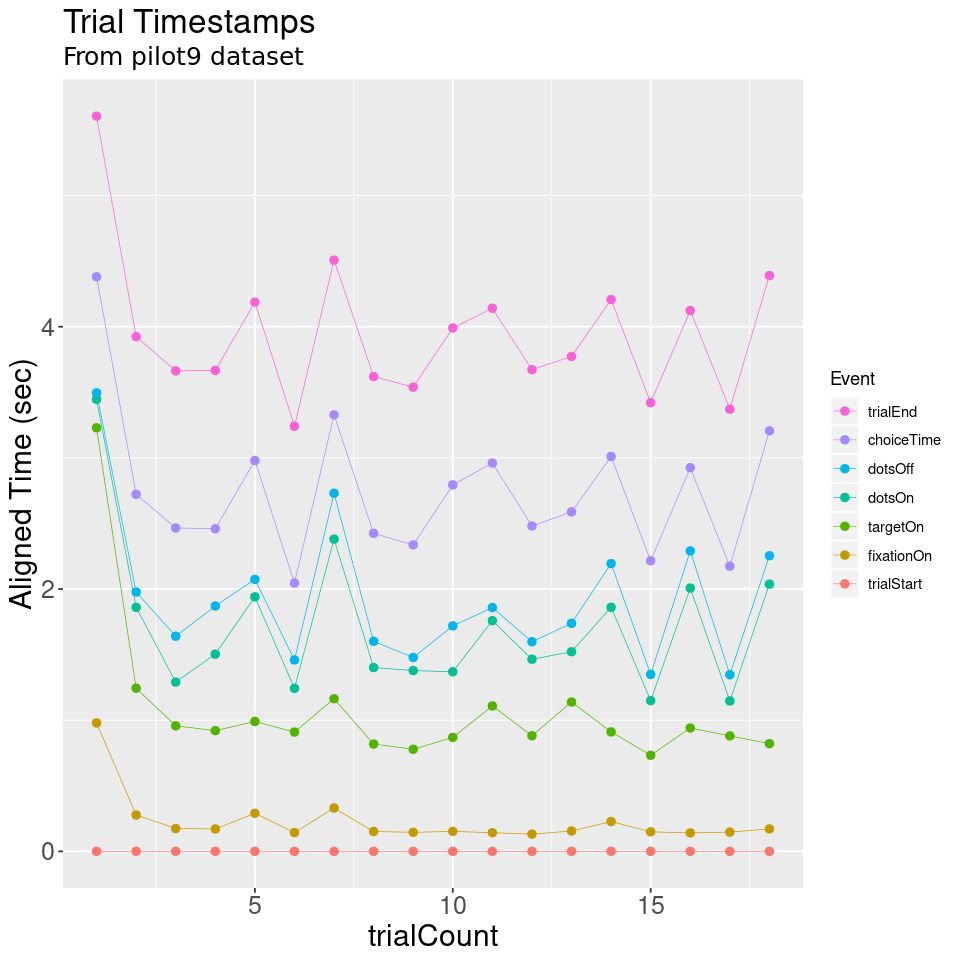

In [16]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=8)
# plot
ggplot(longTimestamps, aes(x=trialCount, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- How precise were the dots timings?  

We plot `(dotsOff - dotsOn) - viewingDuration`, across all trials, and overlay average durations of 1 and 2 frames (dashed lines).

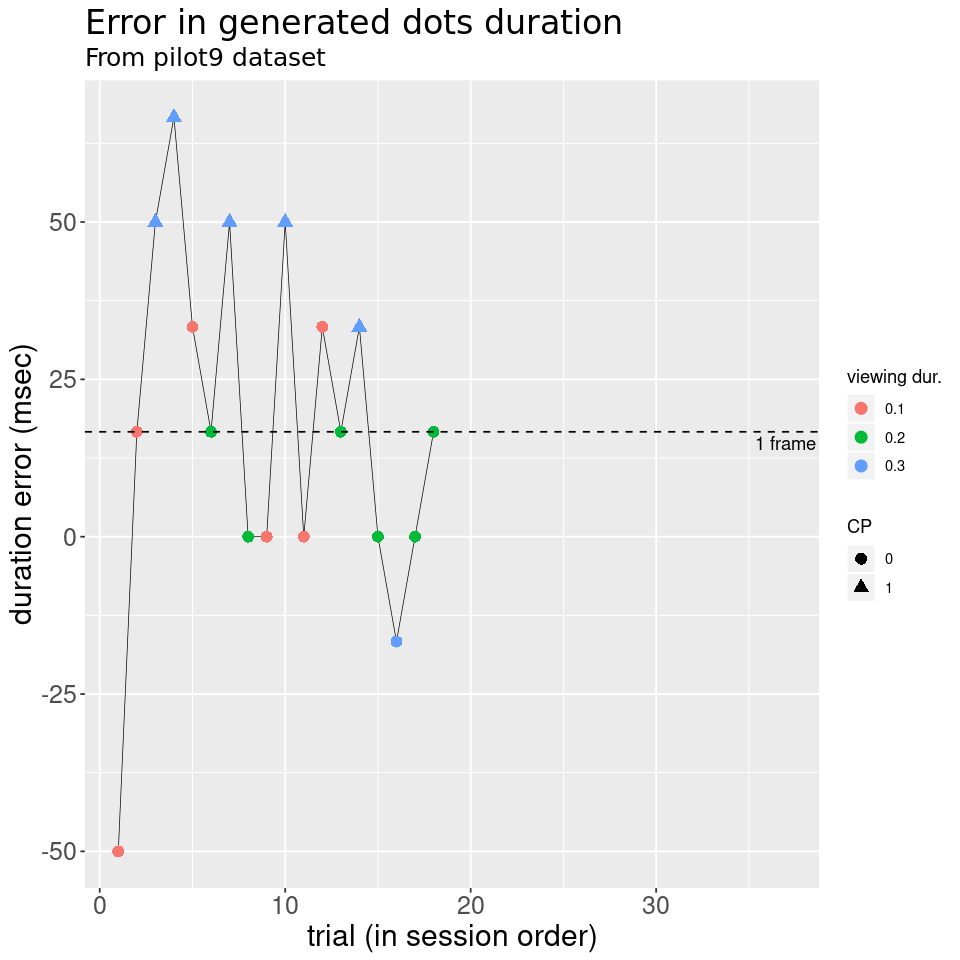

In [17]:
durTable <- tb[[TRIALS]][,.(dotsDurationError = (dotsOff - dotsOn - viewingDuration) * 1000, 
                            presenceCP, 
                            viewingDuration), 
                        by=trialCount]
# str(durTable)
# call to ggplot()
g <- ggplot(durTable, aes(x=trialCount, y=dotsDurationError)) + 
  geom_line(size=.2) +  
  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) +
  geom_hline(yintercept = FRAME_DURATION*1000, linetype="dashed") +
  annotate("text", x=37, y=FRAME_DURATION*1000, vjust = 1.3, label = c("1 frame"))
# Add Title and Labels
g + labs(title="Error in generated dots duration", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="duration error (msec)", 
         x="trial (in session order)",
         color="viewing dur.", shape="CP") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

Below I try to estimat the mean errors, clustered. 

In [18]:
print("empty for now")
# intervals <- bin(durTable[,.(dotsDurationError)], nbins = 3, method = "cluster")
# names(intervals) <- "interval"

# # add the bins as a factor to the data.table
# durTable[, ("interval") := intervals]

# # compute mean durations
# unordered <- durTable[, .(num_trials=.N, meanDurationError = mean(dotsDurationError)), by = intervals]

# # display results, with num_frame column
# unordered[order(meanDurationError),.(num_trials, meanDurationError, num_frames = (meanDurationError * FRAME_RATE_ESTIMATE / 1000))]

[1] "empty for now"


Below I specifically compare the `dotsOn` and `dotsOff` values that I got from the task and from the `tic/toc` calls.

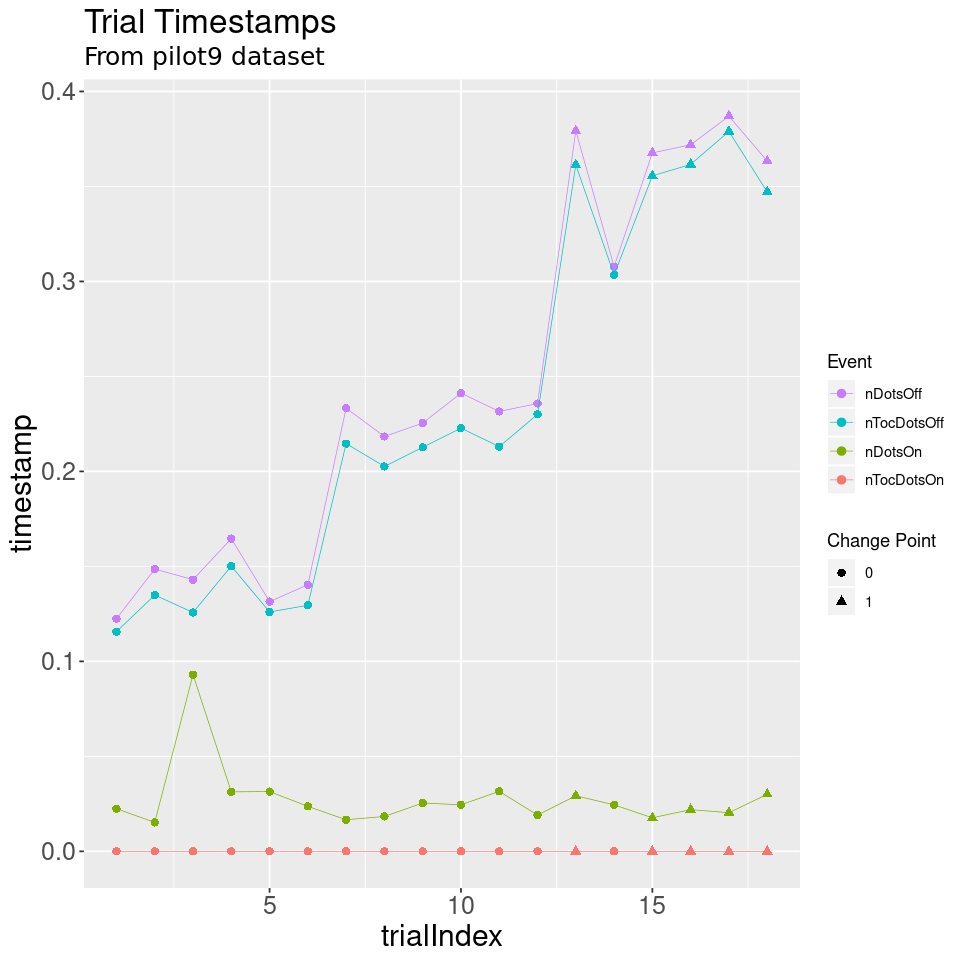

In [21]:
longDotsOffTimestamps <- melt(wideTimestamps,
                       id.vars=c("trialIndex","presenceCP"),
                       measure.vars=c("nTocDotsOn","nDotsOn","nTocDotsOff","nDotsOff"),
                       value.name="timestamp", variable.name="Event")

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longDotsOffTimestamps, aes(x=trialIndex, y=timestamp)) + 
   geom_point(aes(col=Event, shape=factor(presenceCP)), size=2) +
   geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
    guides(colour = guide_legend(reverse=T)) +
    labs(title="Trial Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
        shape="Change Point") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Checking that the three datasets are consistent
As we can see, the `frameIdx` field is common to `tb[[FRAMES]]` and `tb[[DOTS]]`, and the `trialIdx` is common to `tb[[DOTS]]` and `tb[[TRIALS]]`. Let's check whether these common fields match in terms of their unique values in each dataset.

## Exploring match between `DOTS` and `TRIALS` levels

## Exploring match between `FRAMES` and `TRIALS` levels
### Timing of trial vs. timing of frames

In [ ]:
# add (bug-corrected) dotsOn, dotsOff values to filter swapTimes
# add trialStart for future offset
# the syntax is that of a right join
frameTimes <- tb[[FRAMES]][tb[[TRIALS]][,.(trialStart, 
                                           dotsOn, 
                                           dotsOff, 
                                           trialIndex)], on="trialIndex"]

# only consider frames with onsetTime in-between dotsOn and dotsOff
frameTimes <- frameTimes[onsetTime-trialStart>=dotsOn & onsetTime-trialStart <= dotsOff]
# str(frameTimes)

- does the "number of frames" match across the three files?

In [ ]:
setkey(frameTimes, trialIndex)
setkey(tb[[TRIALS]], trialIndex)

# Full OUTER JOIN (see https://rstudio-pubs-static.s3.amazonaws.com/52230_5ae0d25125b544caab32f75f0360e775.html)
frameCount <- merge(
    tb[[TRIALS]][,.(numInTRIALS=numFrames, trialCount),by=trialIndex],
    frameTimes[,.(numInFRAMES=.N),by=trialIndex],
    all=TRUE)

# str(frameCount)

In [ ]:
frameCount <- frameCount[tb[[DOTS]][order(trialIndex),.(numInDOTS=max(frameIdx)),by=trialIndex],on="trialIndex"]
frameCount[,.(trialIndex, trialCount, numInTRIALS,numInFRAMES,numInDOTS,match=numInFRAMES == numInDOTS)]

From the columns above, we see that:
- the `numFrames` field from the `tb[[TRIALS]]` table is not useful
- I should match dots and frames using timestamps

- what time gaps do I observe between `dotsOn` and 1st frame `onsetTime`, and last frame `onsetTime` and `dotsOff`?

In [ ]:
# get times of first and last frame in each trial, align everything to dotsOn
extremeFrameTimes <- frameTimes[,.(firstFrame=min(onsetTime-trialStart)-dotsOn, 
                                   lastFrame=max(onsetTime-trialStart)-dotsOn,
                                   trialStart, 
                                   dotsOn=dotsOn-dotsOn, 
                                   dotsOff=dotsOff-dotsOn,
                                   trialCount),
                                  by=trialIndex]
# str(extremeFrameTimes)

In [ ]:
1.3# transform to long format for ggplot 
longTimeData <- melt(extremeFrameTimes, 
                    id.vars=c("trialIndex"),
                    measure.vars=c("dotsOn","firstFrame","lastFrame","dotsOff"),
                    variable.name="Event", value.name="timestamp")
#str(longTimeData)


frameDurations <- c(6*FRAME_DURATION, 140*FRAME_DURATION)

# control output figure size
options(repr.plot.width=8, repr.plot.height=8)

# plot
ggplot(longTimeData, aes(x=trialIndex, y=timestamp)) + geom_point(aes(col=Event), size=2) +
   geom_line(aes(col=Event),size=.2) +
   geom_hline(yintercept = FRAME_DURATION, linetype="dashed") +
   annotate("text", x=16, y=FRAME_DURATION, vjust = -1, label = c("1 frame")) +
   guides(colour = guide_legend(reverse=T)) +
   labs(title="Stimulus Timestamps",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="Aligned Time (sec)") + theme(plot.title=element_text(size=20,
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15,
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

- Exploration of `Tight` frames in each trial

In [ ]:
# plot
ggplot(frameTimes, aes(x=trialIndex, y=onsetTime-(dotsOn+trialStart))) + 
   geom_point(aes(col=factor(isTight)), size=2) +
#    geom_line(aes(col=Event),size=.2) +
#    geom_hline(yintercept = frameDurations, linetype="dashed") +
#    guides(colour = guide_legend(reverse=T)) +
   labs(title="Tight/Untight Frames",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="onsetTime aligned to dotsOn (sec)",
        color="Tight") + 
   theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

## Exploring match between `FRAMES` and `DOTS`

In [ ]:
# unique(tb[[DOTS]][,frameIdx])
# tb[[DOTS]][order(trialIndex),.(frameIdx), by=.(trialIndex, frameIdx)]

# Accuracy analysis
- Accuracy (% correct) on the task

In [ ]:
accuracy <- sum(tb[[TRIALS]][,correct])/numTrials
cat(accuracy * 100,"%", sep = '')

- Accuracy on CP vs. non-CP trials

In [ ]:
# count CP and Non-CP trials
cpGrouping <- getFreq(tb[[TRIALS]], "presenceCP")
numCPtrials <- cpGrouping[presenceCP == 1, freq.]
numNonCPtrials <- cpGrouping[presenceCP == 0, freq.]

# compute accuracies in each group of trials
accuracy_CP <- sum(tb[[TRIALS]][presenceCP == 1, correct])/numCPtrials * 100
accuracy_nonCP <- sum(tb[[TRIALS]][presenceCP == 0, correct])/numNonCPtrials * 100
# round to 2 decimals
accuracy_CP <- round(accuracy_CP, digits = 2)
accuracy_nonCP <- round(accuracy_nonCP, digits = 2)

# display summarizing table
toDisplay <- cpGrouping[, ("accuracy") := data.frame("accuracy"=c(accuracy_nonCP, accuracy_CP))]
print(toDisplay)
# toDisplay # print a second time because of a bug that I don't fully understand (see https://github.com/IRkernel/IRkernel/issues/127 and https://github.com/rstudio/rmarkdown/issues/1002)

- Accuracy as a function of viewing duration

In [ ]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][order(viewingDuration),.(freq = .N, correct = sum(correct)), by=viewingDuration]

# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

- Accuracy as a function of coherence level

In [ ]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][order(coherence),.(freq = .N, correct = sum(correct)), by=coherence]

# then add the accuracy column
toDisplay <- toDisplay[,.(coherence, freq, correct, accuracy = round(correct/freq*100,digits=2))]
toDisplay

- Group by change point presence after CP time

In [ ]:
# first get marginal frequencies
toDisplay <- tb[[TRIALS]][viewingDuration > .2,
                  .(freq = .N, correct = sum(correct)), 
                  by=.(viewingDuration, presenceCP)]
# then add the accuracy column
toDisplay <- toDisplay[,.(viewingDuration, freq, correct, presenceCP,  accuracy = round(correct/freq*100,digits=2))]
toDisplay

# Reverse Kernel Analysis

Let's display the number of coherent dots on each frames, grouping by subject's choice.

In [ ]:
# count coherent dots on each frame
cohDots <- tb[[DOTS]][,
                      .(numCohDots=sum(isCoherent), 
                        initDirection, 
                        endDirection, 
                        presenceCP),
                      by=.(frameIdx, trialCount)]

# see if some frames have 0 coherent dots
unique(cohDots[numCohDots == 0,.(trialCount,frameIdx)])

In [ ]:
# let's try to sign numCohDots according to the direction of motion (+ for R and - for L)
## add a copy of numCohDots column named signedNumCohDots, and an ID col that just indexes the rows
cohDots[,"signedNumCohDots" := .(numCohDots)]

In [ ]:
## on non-cp trials, adjust sign according to initDirection
cohDots[initDirection == 180 & presenceCP == 0, signedNumCohDots := -numCohDots] 

In [ ]:
## on cp-trials,
    # rough estimate of number of frames that are before the CP (for now)
if (length(unique(tb[[TRIALS]]$timeCP)) == 1) {
    foreFrameCount <- tb[[TRIALS]][,timeCP][1] * FRAME_RATE_ESTIMATE
} 

In [ ]:
foreFrameCount

In [ ]:
rows <- cohDots[, .(rowNumber=.I[initDirection==180 & presenceCP == 1]), by=.(trialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx <= foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx <= foreFrameCount,rowNumber]]

In [ ]:
rows <- cohDots[, .(rowNumber=.I[initDirection==0 & presenceCP == 1]), by=.(trialCount,frameIdx)]
cohDots[["signedNumCohDots"]][
    rows[frameIdx > foreFrameCount,rowNumber]] <- -cohDots[["numCohDots"]][
        rows[frameIdx > foreFrameCount,rowNumber]]

In [ ]:
# diagnostic
unique(cohDots[presenceCP == 1,
               .(initDirection,endDirection,presenceCP,numCohDots,signedNumCohDots) ,
               by=.(frameIdx,trialCount)])

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=60)

# add ID col to tb[[DOTS]] and cohDots to perform a join
tb[[DOTS]][,ID:=.I]
cohDots[,rowNumber := NULL]
cohDots[,ID:=.I]

# plot
ggplot(tb[[DOTS]][cohDots, on=c("ID","frameIdx","trialCount")], aes(x=frameIdx, y=signedNumCohDots)) + 
    geom_point(aes(col=factor(correct), shape=factor(presenceCP)), size=2) +
    facet_grid(trialIndex~coherence) +
#    geom_line(aes(col=Event),size=.2) +
    geom_hline(yintercept = 0) +
    guides(colour = guide_legend(reverse=T), shape = guide_legend(reverse=T)) +
    labs(title="Signed # of Coherent Dots per Frames per Trials",
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""),
         y="# Coherent Dots",
         x="Frame #",
         color="Correct", shape="Change Point") + 
    theme(plot.title=element_text(size=20, lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),                                 # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text

# Miscellaneous
##  Explore random seed

In [ ]:
seedTable <- tb[[TRIALS]][,.(randSeedBase,trialIndex),by=trialCount]

# control output figure size
options(repr.plot.width=7, repr.plot.height=6)

g <- ggplot(seedTable, aes(x=trialCount, y=randSeedBase)) + 
  geom_line(size=.2) #+  geom_point(aes(shape=factor(presenceCP), col=factor(viewingDuration)),size=3) 

# Add Title and Labels
g + labs(title="Random seed base", 
         subtitle=paste("From pilot",PILOT_NUMBER," dataset",sep=""), 
         y="randSeedBase", 
         x="trial (in session order)") + theme(plot.title=element_text(size=20, 
                                    family="American Typewriter",
                                    color="tomato",
                                    lineheight=1.2),  # title
            plot.subtitle=element_text(size=15, 
                                       family="American Typewriter"),  # subtitle
            plot.caption=element_text(size=15),  # caption
            axis.title.x=element_text(size=AXES_LABEL_FONT),  # X axis title
            axis.title.y=element_text(size=AXES_LABEL_FONT),  # Y axis title
            axis.text.x=element_text(size=AXES_FONT),  # X axis text
            axis.text.y=element_text(size=AXES_FONT))  # Y axis text